In [6]:
import os
import sys
import warnings

warnings.filterwarnings('ignore')

import cv2
import matplotlib.pyplot as plt
import mmcv
import mmengine
import numpy as np
import torch
from mmdet.apis import inference_detector, init_detector

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples
from mmpose.utils import adapt_mmdet_pipeline

In [10]:
from gpat.utils.config import read_config

# Load the configuration file
config = read_config()
pose_model = os.path.expanduser(config["model-setting"]["pose_model"])
pose_checkpoint = os.path.expanduser(config["model-setting"]["pose_checkpoint"])
det_model = os.path.expanduser(config["model-setting"]["det_model"])
det_checkpoint = os.path.expanduser(config["model-setting"]["det_checkpoint"])

In [12]:
det_cat_id: int = 0
bbox_thr: float = 0.3
nms_thr: float = 0.3
iou_thr: float = 0.1
kpt_thr : float = 0.3
radius: int = 5
alpha: float = 0.8
thickness: int = 1
skeleton_style: str = 'mmpose'
draw_heatmap = False
show_kpt_idx = False
show = False
show_interval : int = 0
draw_bbox = False

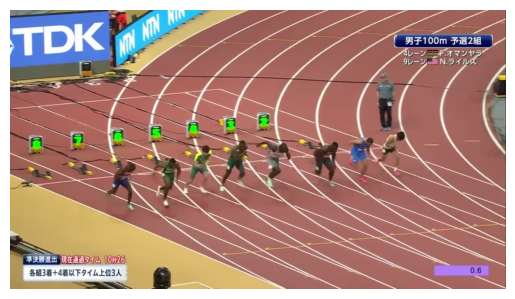

In [15]:
img_path = "./resources/demo.jpg"
img = cv2.imread(img_path)

fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.axis("off")
plt.show()

In [13]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the pose model
pose_estimator = init_pose_estimator(pose_model, pose_checkpoint, device=device)
pose_estimator.cfg.visualizer.radius = radius
pose_estimator.cfg.visualizer.alpha = alpha
pose_estimator.cfg.visualizer.line_width = thickness

# Set the visualizer
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
visualizer.set_dataset_meta(pose_estimator.dataset_meta, skeleton_style=skeleton_style)

# Load the detection model
detector = init_detector(det_model, det_checkpoint, device=device)
detector.cfg = adapt_mmdet_pipeline(detector.cfg)

Using device: cuda
Loads checkpoint by local backend from path: /home/ohwada/human_pose_estimation/models/rtmpose-l_simcc-coco-wholebody_pt-aic-coco_270e-384x288-eaeb96c8_20230125.pth
Loads checkpoint by local backend from path: /home/ohwada/human_pose_estimation/models/rtmdet_m_8xb32-300e_coco_20220719_112220-229f527c.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std



In [16]:
# Perform detection
det_result = inference_detector(detector, img)
pred_instance = det_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == det_cat_id, pred_instance.scores > bbox_thr)]
bboxes = bboxes[nms(bboxes, nms_thr), :4]

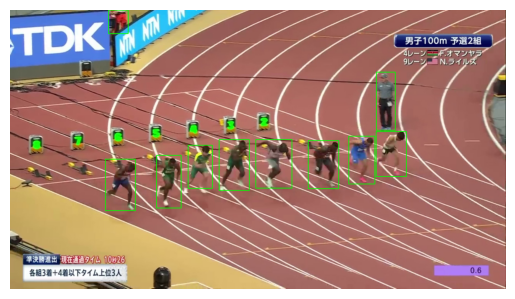

In [17]:
img_copy = img.copy()
for bbox in bboxes:
    bbox = bbox.astype(int)
    cv2.rectangle(img_copy, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
ax.axis("off")
plt.show()

In [18]:
pose_results = inference_topdown(pose_estimator, img, bboxes)
data_samples = merge_data_samples(pose_results)

if isinstance(img, str):
    img = mmcv.imread(img, channel_order='rgb')
elif isinstance(img, np.ndarray):
    img = mmcv.bgr2rgb(img)

# visualize the results
if visualizer is not None:
    visualizer.add_datasample(
        'result',
        img,
        data_sample=data_samples,
        draw_gt=False,
        draw_heatmap=draw_heatmap,
        draw_bbox=draw_bbox,
        show_kpt_idx=show_kpt_idx,
        skeleton_style=skeleton_style,
        show=show,
        wait_time=show_interval,
        kpt_thr=kpt_thr)

03/02 13:40:35 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".


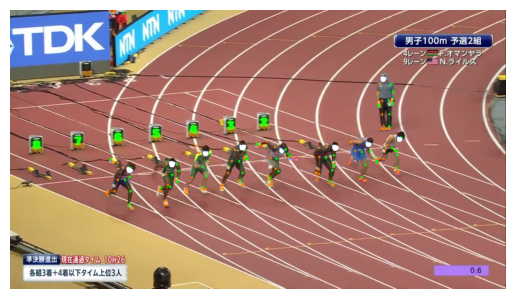

In [20]:
fig, ax = plt.subplots()
ax.imshow(visualizer.get_image())
ax.axis("off")
plt.show()